In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter
import math

import matplotlib.pyplot as plt
import seaborn as sns

from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import json
import os

In [4]:
#Centroid based
#K-Means-Ok
#K-medoids - no es factible implementar debido a que requiere muchos recursos computacionales.
#K-medians-Ok
#Fuzzy C means

#Other clustering algorithms:
#DBSCAN
#HDBSCAN
#Self Organizing Maps
#BIRCH


In [5]:
def distancia_euc(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p) * math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p))/2
    d = 12742 * math.asin(math.sqrt(a))
    return  d

In [6]:
def fcm_clusters_radios(X,n_clusters):
    
    #Crear copia de base de datos y obtener coordenadas
    data_delitos_fcm = np.array([X['longitud'],X['latitud']])
    data_delitos_fcm = data_delitos_fcm.transpose()
    data_delitos_fcm = data_delitos_fcm.tolist()

    #Crear lista con medias iniciales
    centros_apriori = kmeans_plusplus_initializer(data_delitos_fcm, n_clusters, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
    
    #Instanciar modelo y alimentar datos
    fcm_inst = fcm(data_delitos_fcm,centros_apriori)
    fcm_inst.process()
    y_fcm = fcm_inst.get_clusters()
    centros = fcm_inst.get_centers()
    
    #Añadir labels a dataframe
    y_fcm_labels = [i for i in range(len(y_fcm)) for j in range(len(y_fcm[i]))]
    y_fcm_index = [j for i in y_fcm for j in i]
    y_fcm_df = pd.DataFrame(zip(y_fcm_index,y_fcm_labels),columns=('index','fcm_cluster'))
    y_fcm_df = y_fcm_df.sort_values(by='index',ascending=True)
    y_fcm_df.set_index('index',inplace=True)
    X['fcm_labels'] = y_fcm_df['fcm_cluster']
    
    #Obtener centroides y radios.
    centroide_cluster = dict()
    max_vector_cluster = dict()

    for cluster in list(set(y_fcm_labels)):

        centroide_cluster[cluster]= centros[cluster]

        vector_list = []
        for i in zip(X[X['fcm_labels']==cluster].loc[:,'longitud'],X[X['fcm_labels']==cluster].loc[:,'latitud']):
                vector_list.append((i,np.linalg.norm(np.subtract(i,centroide_cluster[cluster]))))
        max_vector_cluster[cluster] = max(vector_list, key=itemgetter(1))[0]
    
    #Obtener max radios
    radio_clusters = dict()
    radio_clusters = [distancia_euc(centroide_cluster[i][1],centroide_cluster[i][0],max_vector_cluster[i][1],max_vector_cluster[i][0]) for i in set(y_fcm_labels)]
    
    
    return len(np.unique(y_fcm_labels)),max(radio_clusters), X, radio_clusters, centroide_cluster

In [4]:
# Importa base de datos
data_delitos = pd.read_csv('data_limpia.csv')
data_delitos.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
#Ejecutar la clusterización para el rango de número clústeres elegido.

resultados = dict()
radios = dict()
centroides = dict()
for i in range(100,110,10):
    clusters, radio, data_delitos_fcm, radio_clusters, centroide_cluster = fcm_clusters_radios(data_delitos,i)
    resultados[clusters]=radio
    data_delitos_fcm.to_csv(f'data_delitos_fcm{i}.csv')
    radios[clusters] = radio_clusters
    centroides[clusters] = centroide_cluster

MemoryError: 

In [8]:
resultados

{80: 8.815962157068734, 90: 8.547929521912442}

In [ ]:
resultados

{50: 13.664771245615212,
 60: 13.70240222956958,
 70: 9.083854385022192,
 80: 8.897684260922599,
 90: 8.54227877330369,
 100: 8.197649858517332,
 110: 8.176412405067133,
 120: 8.11902352937711,
 130: 8.037301431141959,
 140: 8.050150678020339}

In [9]:
resultados

{190: 7.3678928183580705}

In [ ]:
resultados

{200: 7.444870084456169}

In [11]:
resultados

{50: 15.616173613957388}

In [10]:
resultados

{150: 8.014930818227151}

In [ ]:
data_delitos_fcm.head()

,fecha_hechos,delito,longitud,latitud,fcm_labels
0,2016-01-31 20:50:00,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,-99.108403,19.352859,88
1,2016-01-31 22:00:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,-98.976379,19.331633,22
2,2016-01-31 16:00:00,LESIONES INTENCIONALES POR ARMA DE FUEGO,-99.131745,19.469282,97
3,2016-02-01 06:40:00,LESIONES CULPOSAS,-99.172158,19.443426,18
4,2016-01-31 07:00:00,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,-99.226325,19.300162,103


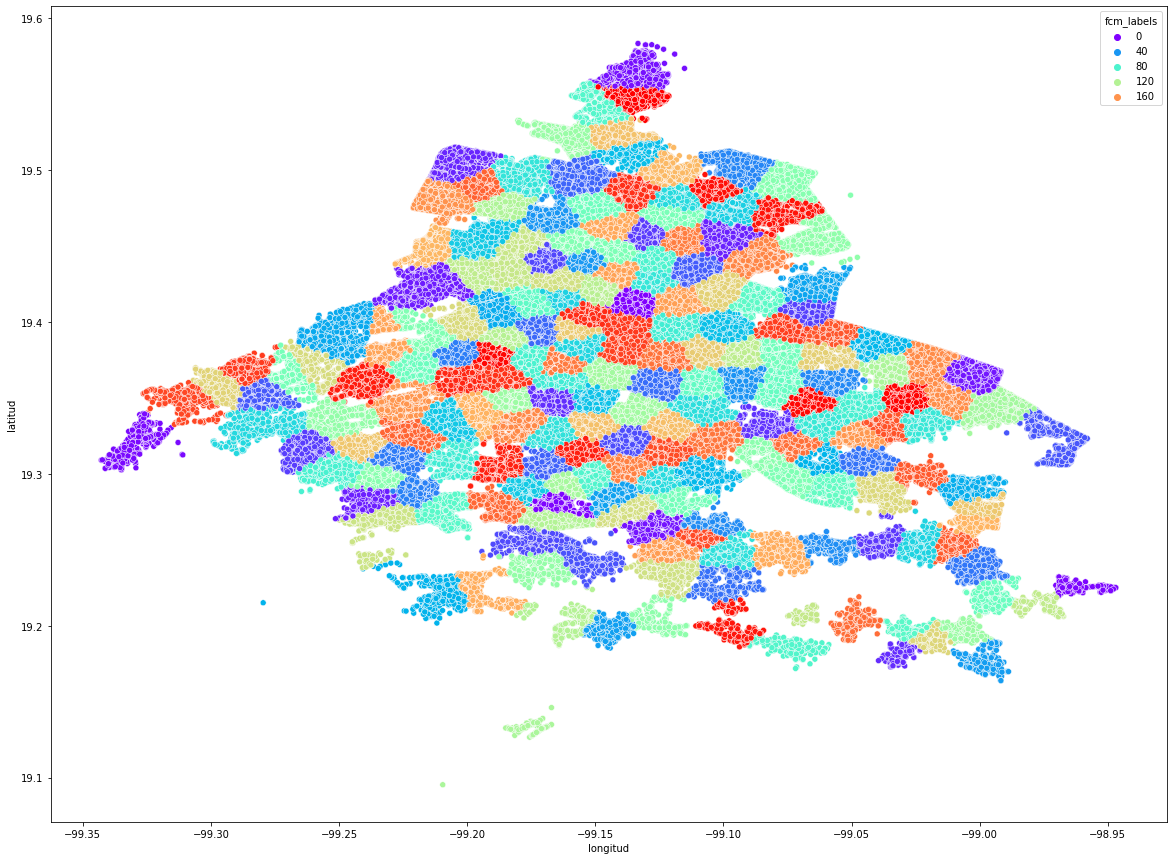

In [ ]:
# Imprime representación clusters
plt.figure(figsize=(20, 15))
sns.scatterplot(data=data_delitos_fcm,x='longitud', y='latitud', hue='fcm_labels', palette='rainbow')

In [ ]:
radios

In [9]:
centroides

NameError: ignored

In [9]:
centroides2 = dict()
for i in centroides:
    centroides2[int(i)] = {int(k):v for k,v in centroides[i].items()}

In [ ]:
centroides2

In [10]:
with open('radios_clusters_fcm.json','w') as outfile:
    json.dump(radios, outfile)

In [11]:
with open('centroides_clusters_fcm.json','w') as outfile:
    json.dump(centroides2, outfile)

In [ ]:
centroides_json = open('/content/drive/MyDrive/Proyecto Final IronHack/Primer experimento kmeans/centroides_clusters_kmeans.json')
radios_json = open('/content/drive/MyDrive/Proyecto Final IronHack/Primer experimento kmeans/radios_clusters_kmeans.json')

centroides = json.load(centroides_json)
radios = json.load(radios_json)

In [8]:
radios

NameError: ignored

In [ ]:
#Calcular el radio máximo al 95% de significancia.
resultados = dict()
for n_k in radios:
  perc_95 = np.percentile(radios[n_k],95)
  radio_max = 0
  for radio in radios[n_k]:
    if radio <= perc_95 and radio > radio_max:
        radio_max = radio
  resultados[n_k]= radio_max

In [ ]:
resultados

In [ ]:
resultados_tiempos = {k:(v/61.2)*3600 for k,v in resultados.items()}

In [ ]:
resultados_tiempos

Text(0, 0.5, 'Tiempo de respuesta máximo (segundos)')

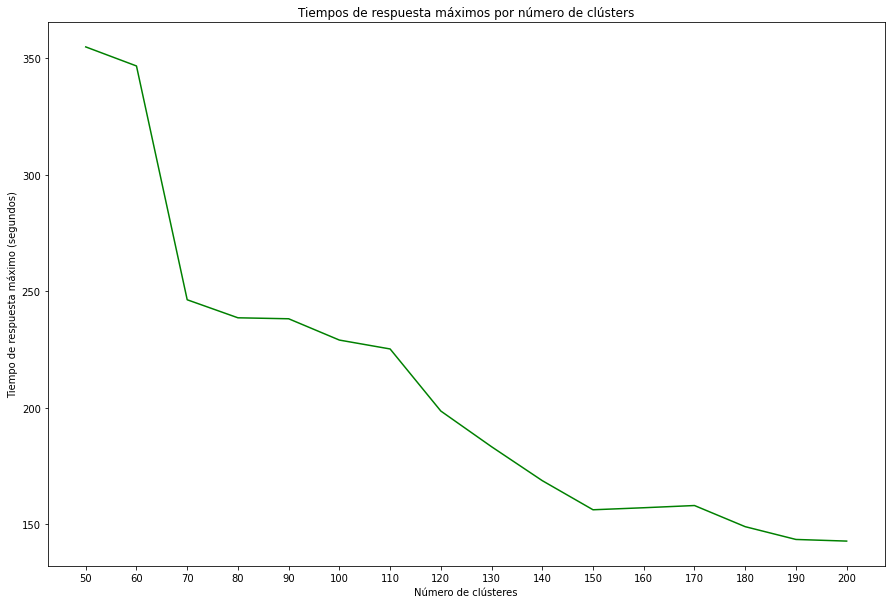

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos.keys()),list(resultados_tiempos.values()),color='green')
plt.title('Tiempos de respuesta máximos por número de clústers')
plt.xlabel('Número de clústeres')
plt.ylabel('Tiempo de respuesta máximo (segundos)')

In [ ]:
# #Estandariza los valores de latitud y longitud
# X = data_delitos.loc[:,['longitud','latitud']]
# scaler = StandardScaler()
# delitos_scale = scaler.fit_transform(X)
# data_delitos_scale = pd.DataFrame(delitos_scale)
